20201004_192420mSPRUT.00
(0.0005, 0.447486866592954)
Не определено точно вступление
20201006_070500mSPRUT.00
(0.7995, 11.664811690253853)
20201016_035110mSPRUT.00
(6.0915, 24.2426337933032)
20201028_155120mSPRUT.00
(6.971, 2.7069336092680962)
20201105_213950mSPRUT.00
(3.041, 1.5266310841774164)
20201110_204540mSPRUT.00
(2.8085, 1.442052892909622)
20201112_015100mSPRUT.00
(9.1635, 8.023784281867606)
20201112_015110mSPRUT.00
(-1.0, -1.0)
Не определено точно вступление
20201120_032720mSPRUT.00
(-1.0, -1.0)
Не определено точно вступление
20201120_032730mSPRUT.00
(0.001, 0.1750822771025817)
Не определено точно вступление
20201122_151757mSPRUT.00
(7.0605, 3.1130693446108264)
20201123_161807mSPRUT.00
(2.4635000000000002, 5.656655223744945)
20201204_044417mSPRUT.00
(0.0035, 0.06310861898498032)
Не определено точно вступление
20201204_044427mSPRUT.00
(-1.0, -1.0)
Не определено точно вступление
20201210_165847mSPRUT.00
(-1.0, -1.0)
Не определено точно вступление
20201210_165857mSPRUT.00
(0.0005,

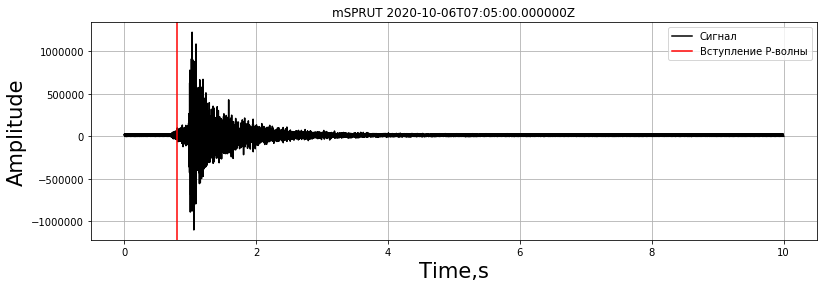

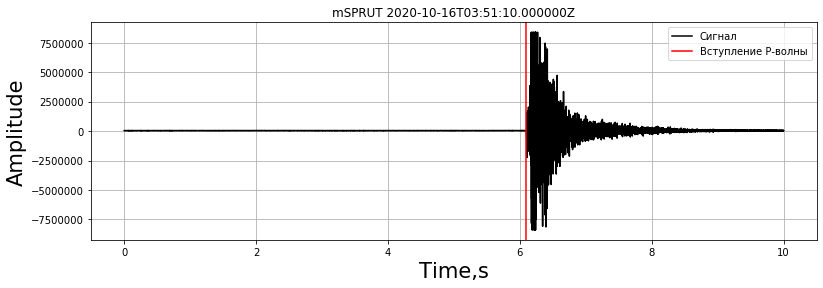

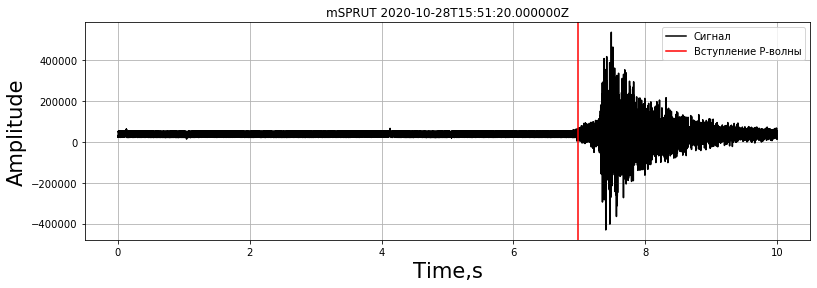

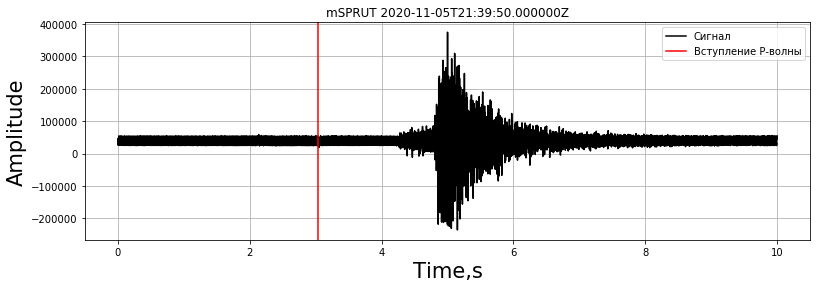

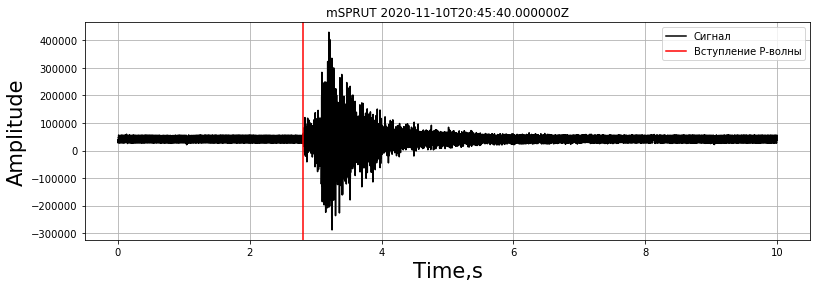

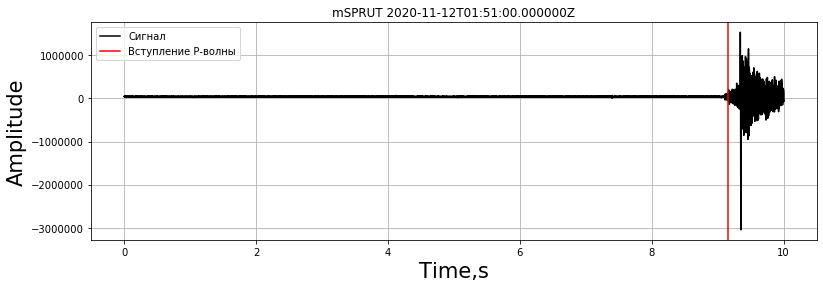

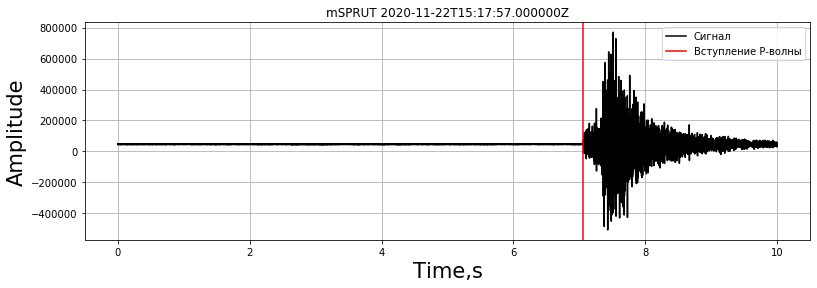

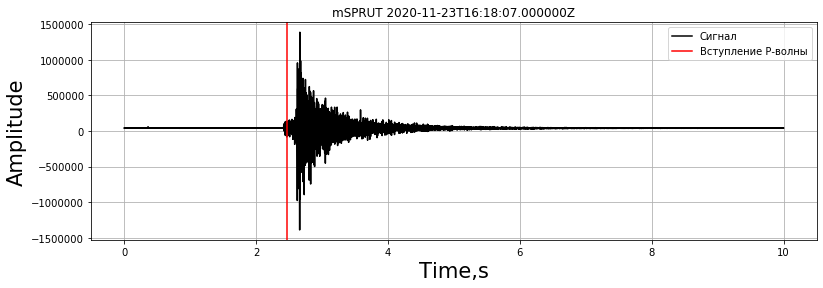

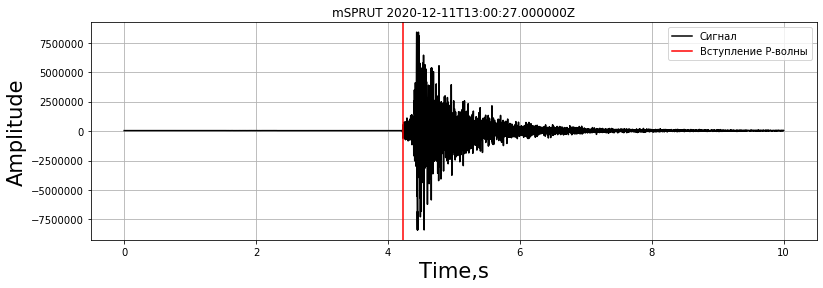

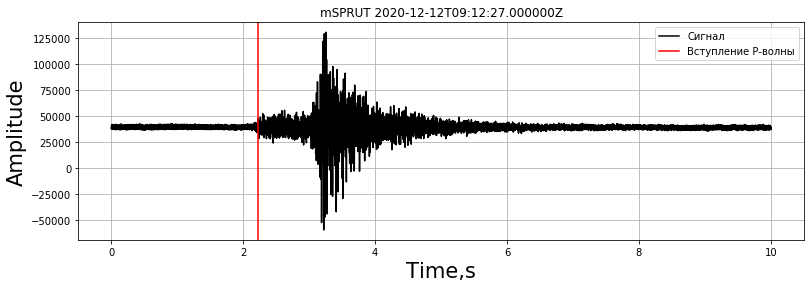

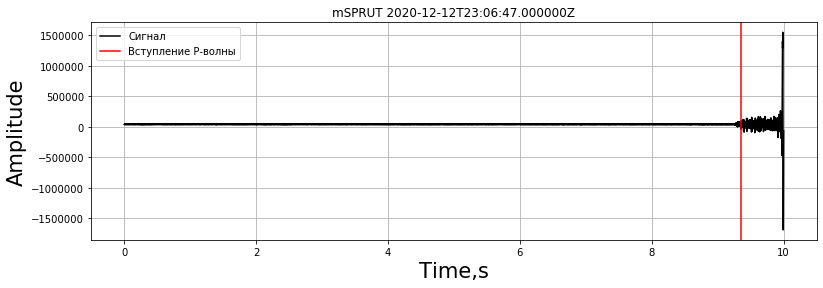

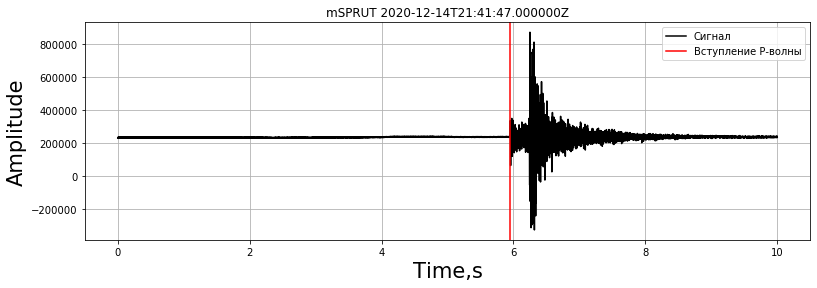

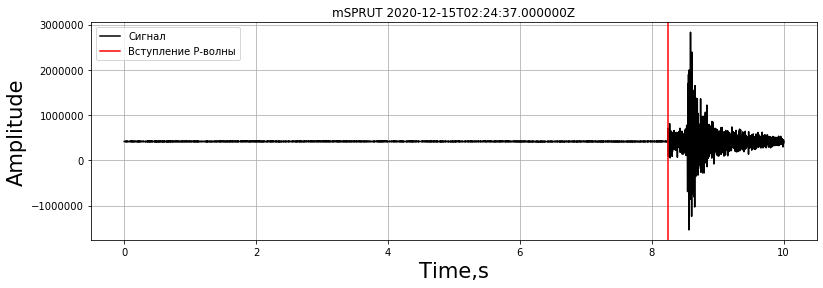

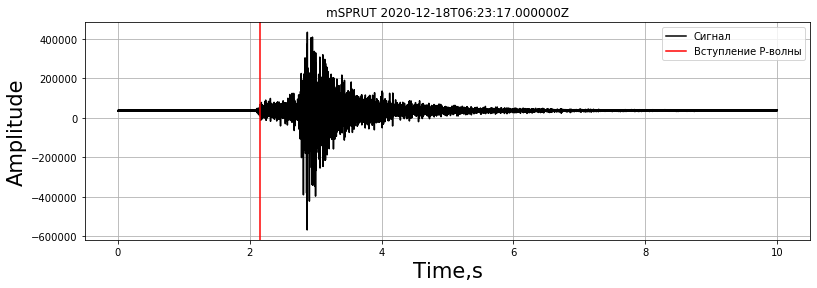

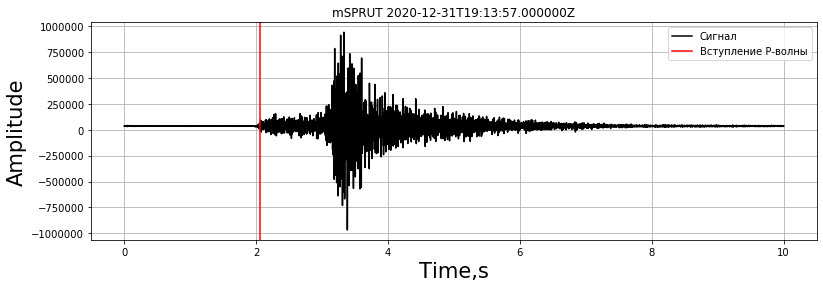

In [20]:
%matplotlib notebook

import os
import numpy as np
import struct as st
import matplotlib.pyplot as plt
import PphasePicker
import obspy as obs

import datetime
begin_time = datetime.datetime.now()

UTC=[] # время пикирование в UTC виде
number_channel=0 # для вызова канала всех файлов

for filename in os.listdir(r"C:\Users\GLEB2001\Питон\Записи\Записи\Скважина 125"):
    if filename.endswith('.00'):
        with open(os.path.join(r"C:\Users\GLEB2001\Питон\Записи\Записи\Скважина 125", filename),'rb') as f: #читаем директорию
            
#---------------------Код сВята-------------------
            data = []
            chanel_number = []
            chanel_name = []
            sensor_type = []
            chanel_coef = []
            chanels = st.unpack('H', f.read(2))[0] # Колличество каналов
            f.read(2)
            version = st.unpack('H', f.read(2))[0] # Версия
            day = st.unpack('H', f.read(2))[0] # День
            month = st.unpack('H', f.read(2))[0] # Месяц
            year = st.unpack('H', f.read(2))[0] # Год
            f.read(6)
            acp = st.unpack('H', f.read(2))[0] # Разрядность АЦП
            f.read(2)
            freq = st.unpack('H', f.read(2))[0] # Частота
            f.read(8)
            station_name = st.unpack('6s10c', f.read(16))[0] # Название станции
            station_name = str(station_name).replace('b', '')
            station_name = station_name.replace("'", '')
            f.read(24)
            lat = st.unpack('d', f.read(8))[0] # Широта
            long = st.unpack('d', f.read(8))[0] # Долгота
            f.read(16)
            time = st.unpack('Q', f.read(8))[0] # Начальное время
            time_start = obs.UTCDateTime(time / 256000000 + 315532800)
            f.read(8)
            
            for i in range(chanels): 
                chanel_number.append(st.unpack('H', f.read(2))[0]) # Номер канала
                f.read(6)
                chanel_name.append(st.unpack('6i', f.read(24))[0]) # Имя канала
                sensor_type.append(st.unpack('6i', f.read(24))[0]) # Тип сенсора
                chanel_coef.append(st.unpack('d', f.read(8))[0]) # Коэффициент канала
                f.read(8)

            for j in range(1000000000):
                try:
                    data.append(st.unpack('i', f.read(4))[0])
                except:
                    break

#---------------------распределяем каналы-------------------------------

            print(filename) # выводим имя файла
            datas=np.zeros((chanels,int(len(data)/chanels))) # создаем массив, где i=число каналов,
                                                                            # j - 20000 (длина 10 секунд)
            
            for i_c in range(chanels):
                datas[number_channel] = data[i_c::chanels] #присваиваем имя канала через datas[0,1,2...],
                                                            #первый канал вызывается datas[0] 
                number_channel+=1 #создаём столько массивов, сколько каналов
                if number_channel==chanels:
                    number_channel=0 # если каналов 32, то он обнуляет number_channel, чтобы при чтении следующего файла начать с 0 

#----------------- считаем вступление, создаём даты, рисуем рисунки

            res = PphasePicker.calculatePphasePicker(datas[0], 0.0005,nbins=200,Tn=0.01, to_peak=False) # меняем каналы!!!!
#calculatePphasePicker(x - Входной сигнал,dt = шаг дискретизации
# Tn - частота осциллятора до демпфирования. По умолчанию: если dt <= 0.01, то Tn = 0.01, иначе Tn = 0.1
# nbins - количество бинов построения гистограммы. По умолчанию: если dt <= 0.01, то int(2/dt), иначе 200
# to_peak - анализирует весь сигнал, а не только до максимума
            print(res)
            x=np.arange(0, int(len(data)/chanels)*0.0005, 0.0005) # создаём по x точки для графика
            if res[0]<=0.1: # ограничение, если посмотреть на вывод, он может определять вступление или -1, то есть не посчитал
# или 0.00... и тогда пикирование идёт в самом начале
                UTC.append(0) # так сказать ошибка в пикировании
                print('Не определено точно вступление')
            else:
                plt.figure(figsize=(13, 4))
                plt.plot(x, datas[0],label='Сигнал',color='black') # меняем каналы!!!!
                plt.axvline(res[0],color='red',label='Вступление P-волны')
                plt.xlabel('Time,s',fontsize=21)
                plt.ylabel('Amplitude',fontsize=21)
                plt.title(station_name + ' ' + str(time_start))
                plt.grid()
                plt.legend()
                UTC.append(time_start+res[0])
print(datetime.datetime.now() - begin_time)

In [26]:
UTC

[0,
 2020-10-06T07:05:00.799500Z,
 2020-10-16T03:51:16.091500Z,
 2020-10-28T15:51:26.971000Z,
 2020-11-05T21:39:53.041000Z,
 2020-11-10T20:45:42.808500Z,
 2020-11-12T01:51:09.163500Z,
 0,
 0,
 0,
 2020-11-22T15:18:04.060500Z,
 2020-11-23T16:18:09.463500Z,
 0,
 0,
 0,
 0,
 2020-12-11T13:00:31.230000Z,
 2020-12-12T09:12:29.229500Z,
 2020-12-12T23:06:56.351000Z,
 0,
 2020-12-14T21:41:52.946000Z,
 2020-12-15T02:24:45.243000Z,
 0,
 2020-12-18T06:23:19.151500Z,
 0,
 0,
 0,
 0,
 2020-12-31T19:13:59.066000Z]